<a name="top"></a> 
# Predicting and Analyzing MLB Team Wins

Overview:

The Texas Rangers are in the offseason, looking to sign players, and want to know which stats drive wins. Are pitchers more important than hitters? Are basic stats just as important as advanced/sabermetric stats? This will help guide them when evaluating free agents.

Project goals:

- Analyze and explore MLB stats to see which stats drive team wins in a season.
- Construct a ML Regression model that predicts team wins in a season.

## Imports

In [1]:
import explore as e
import model as m

import pandas as pd

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

Used Selenium to scrape MLB team stats from [Baseball Reference](https://www.baseball-reference.com)
- Each web page has batting or pitching stats of a certain category (standard stats, advanced stats, etc.) from a certain season.
- Stats from each category and each season are concatenated to make two dataframes: `team_batting` and `team_pitching`
- 2005 to 2022 seasons, not including 2020 due to shortened season.
- 510 rows for each table, each being a season of team stats.

Offensive Stats:

In [2]:
pd.read_csv('data/team_batting.csv').head(3)

,year,W,L,W-L%,Tm,#Bat,BatAge,R/G,G,PA,...,lgBA,lgOBP,lgSLG,lgOPS,OWn%,BtRuns,BtWins,TotA,SecA,PwrSpd
0,2005,88,74,0.543,Philadelphia Phillies,40,30.0,4.98,162,6345,...,0.274,0.345,0.437,0.782,0.555,-17.9,-1.9,0.755,0.285,136.9
1,2005,81,81,0.500,Washington Nationals,55,29.3,3.94,162,6142,...,0.263,0.332,0.418,0.750,0.439,-75.9,-7.5,0.642,0.224,65.0
2,2005,80,82,0.494,Toronto Blue Jays,37,27.9,4.78,162,6233,...,0.271,0.334,0.429,0.763,0.480,-44.3,-4.3,0.685,0.236,94.2


Pitching Stats:

In [3]:
pd.read_csv('data/team_pitching.csv').head(3)

,year,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,...,SO-BB%,XBH%,X/H%,GO/AO,IP%,HR/FB,IF/FB,Opp,DP,%
0,2005,Philadelphia Phillies,19,29.7,4.48,88,74,0.543,4.21,162,...,11.0,8.8,39.0,1.14,68.0,8.9,11.0,1035,111,11.0
1,2005,Washington Nationals,25,28.9,4.15,81,81,0.500,3.87,162,...,7.3,7.0,30.0,0.91,71.0,5.9,12.0,1281,124,10.0
2,2005,Toronto Blue Jays,18,28.2,4.35,80,82,0.494,4.06,162,...,8.3,7.6,32.0,1.15,73.0,8.4,11.0,1151,134,12.0


## Data Analysis

Data is split into training and test data. Analysis is performed on training data to avoid bias and data leakage during modeling. 

Test data is separated to test ML regression models later in the project.

**Which features correlate most to wins?**

Only analyzed stats that are not calculated off wins (`W`) or runs (`R`), which will have an obvious bias towards wins.

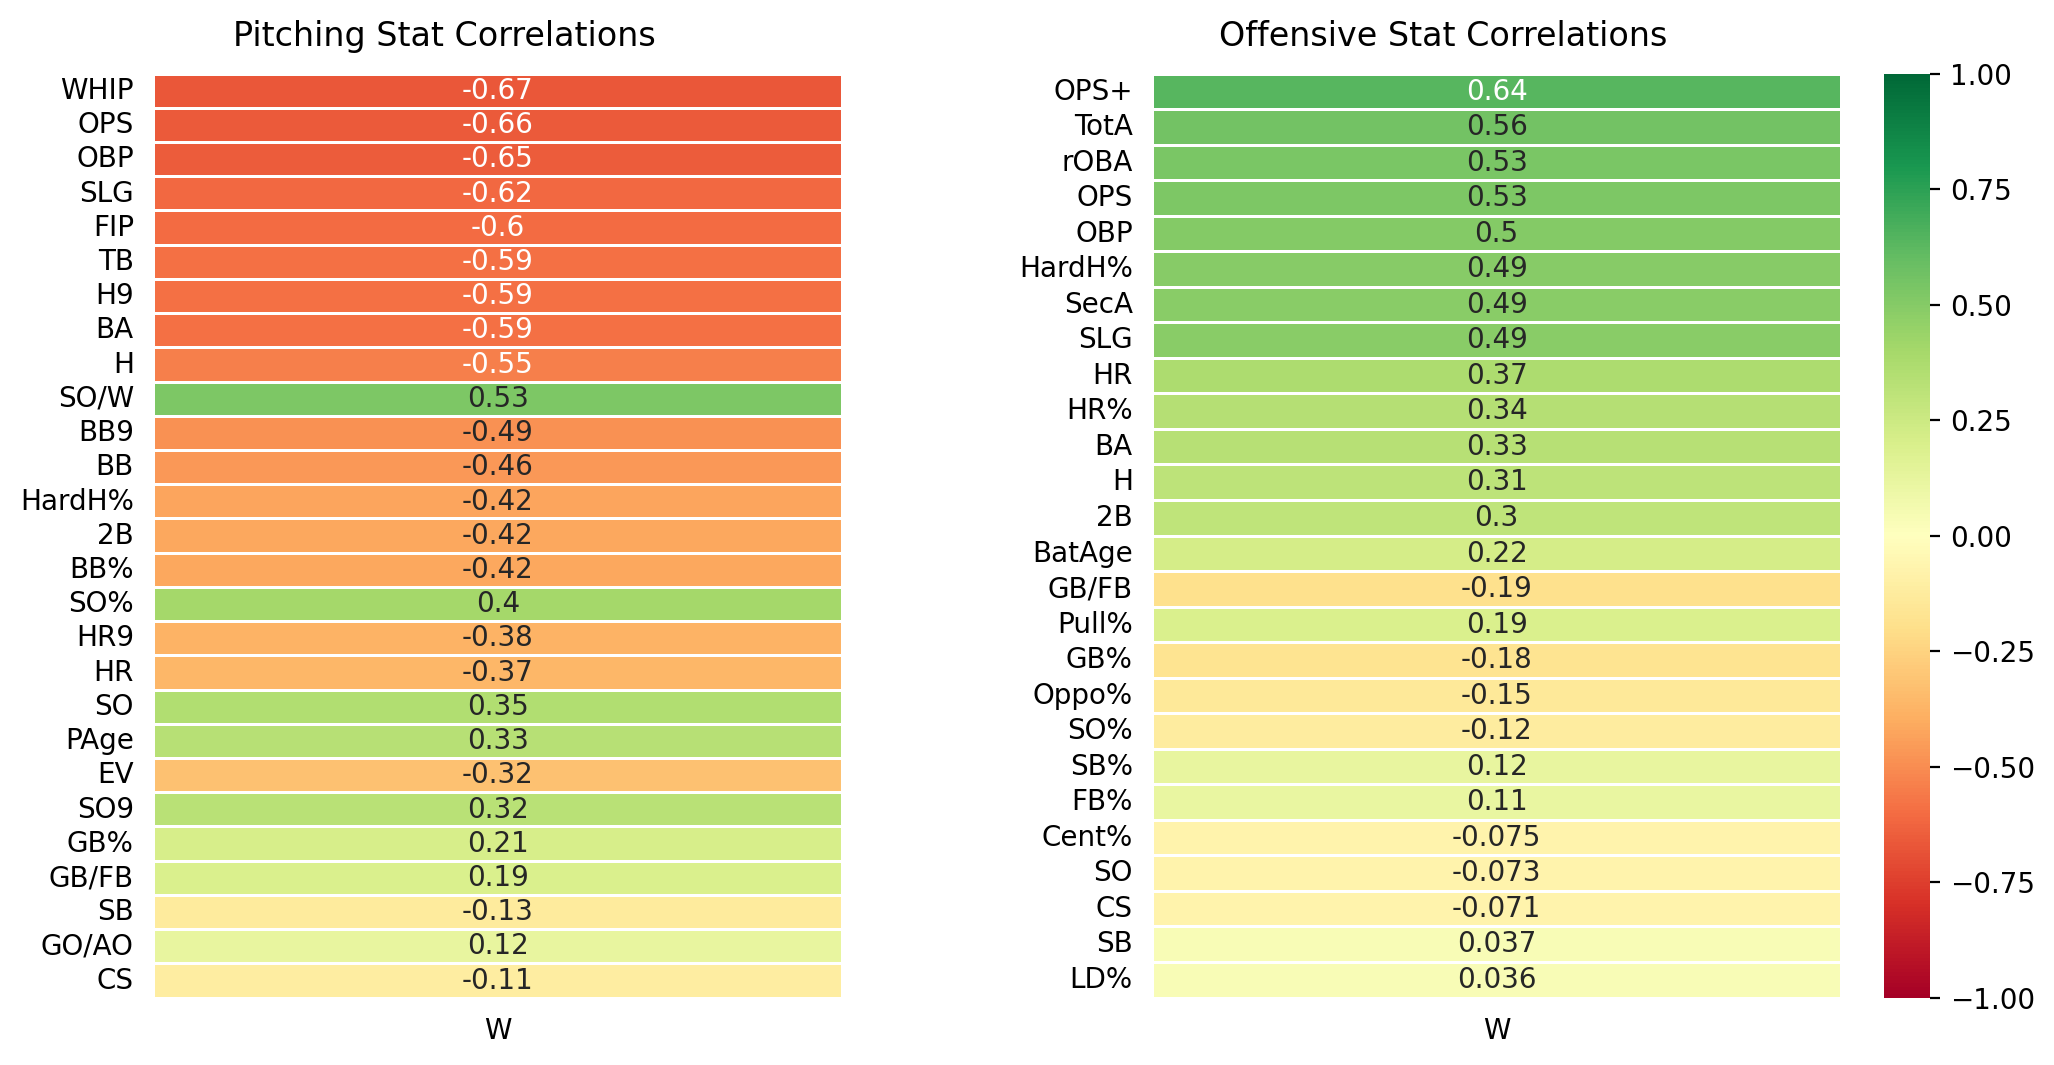

In [4]:
e.plot_key_corrs()

**Insights**
<a name="insights"></a>

[Reference](#ref) for key stats at the bottom of this notebook

Pitching Insights:
- Stats that predict wins
    - `OPS`
    - `WHIP`
    - `FIP`
- Stats that don't predict wins well:
    - baserunning (`SB`, `CS`), groundouts/airouts (`GO/AO`)

Offensive Insights:
- Stats that predict wins:
    - `OPS+`
    - `TotA`
    - `rOBA`
    - hard hits (`HardH%`)
- Stats that don't predict wins well:
    - strikeouts (`SO%`), `SB`, `Cent%`, triples (`3B`)
- `Pull%` leads to more wins than `Cent%` and `Oppo%`. As predictors of wins, however, these relationships aren't as strong as other stats, like `OPS`.
- Pitching stats overall correlate more to wins than offensive stats

**1. Teams that pull the ball win more than those that don't.**

Correlations to Wins:
- $Pull\% = .19$
- $Cent\% = -.07$
- $Oppo\% = -.15$

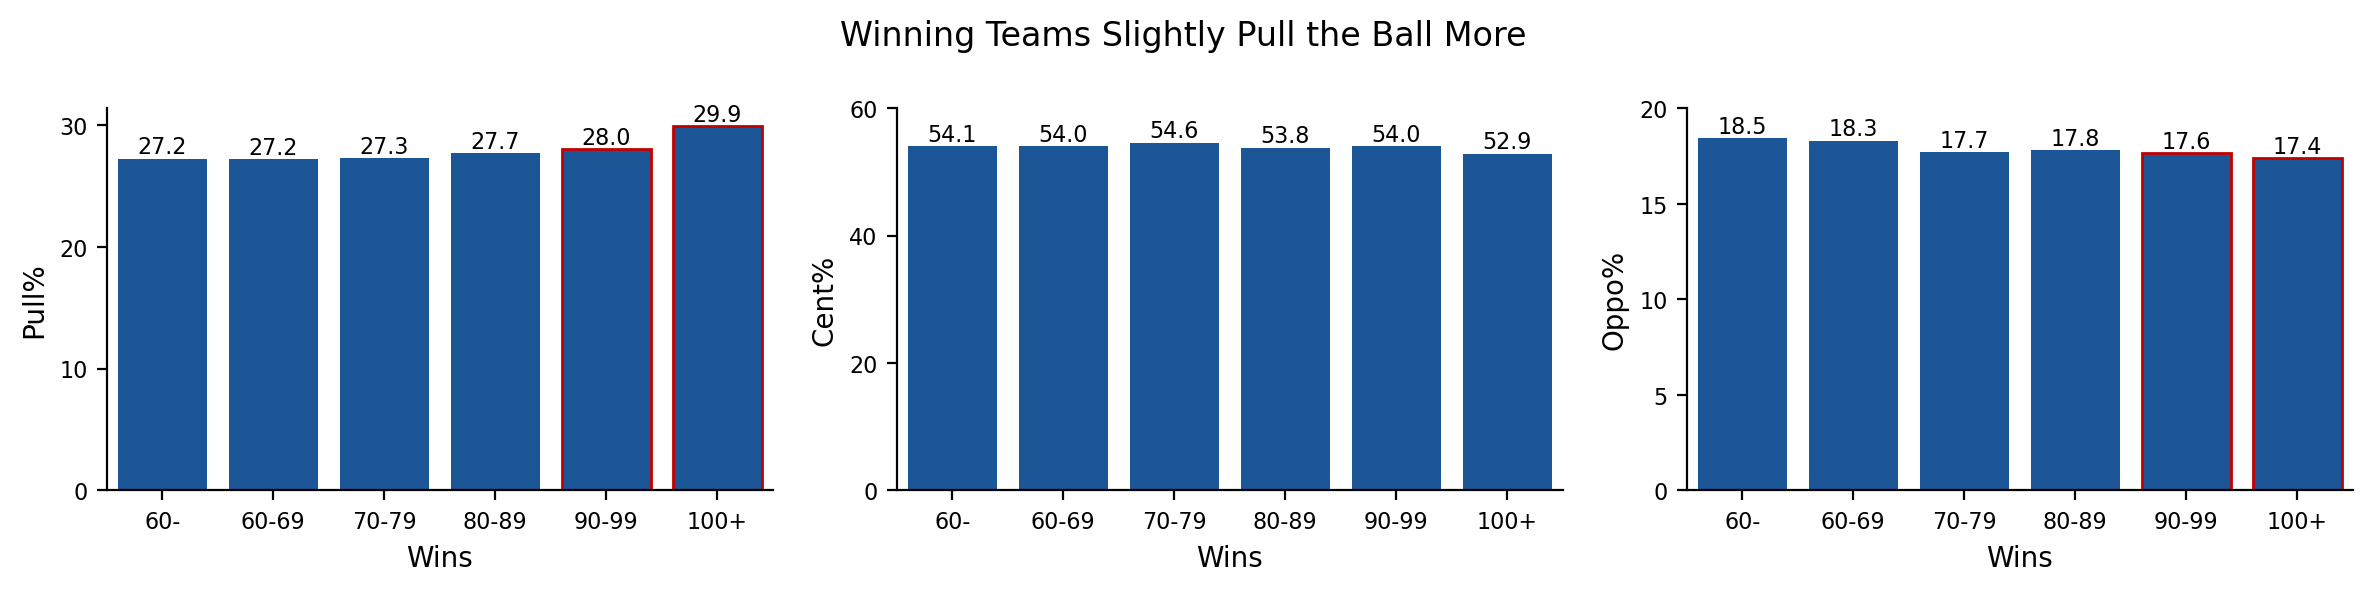

In [5]:
e.plot_percent_medians()

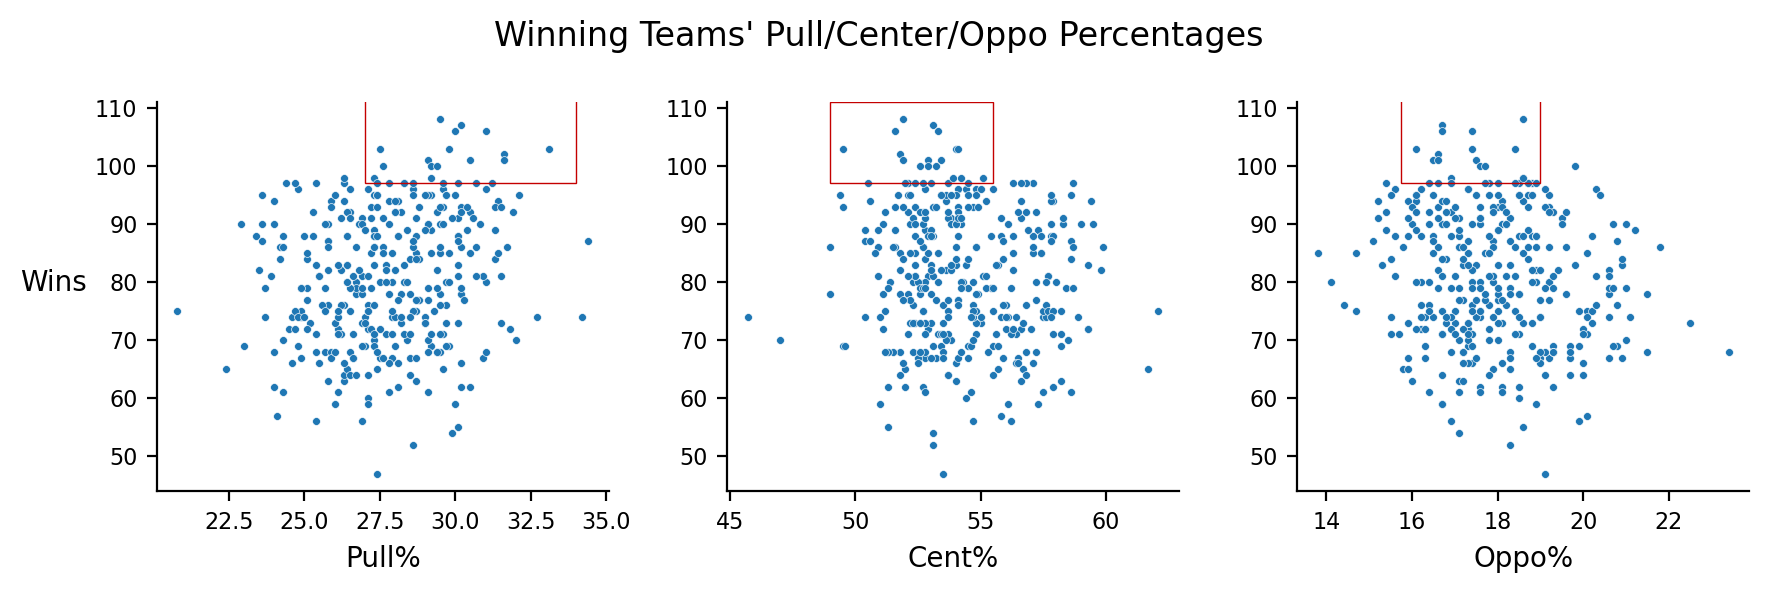

In [6]:
e.plot_wins_vs_percentages()

**2. OPS/OPS+ lead to more wins**

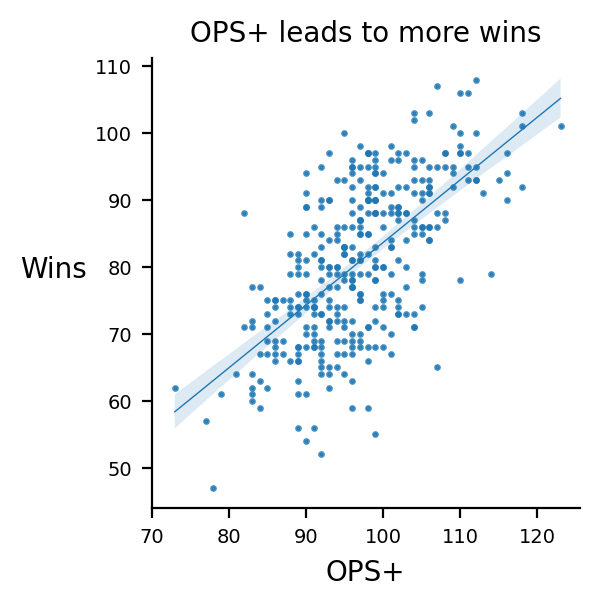

In [7]:
e.plot_W_by_OPS()

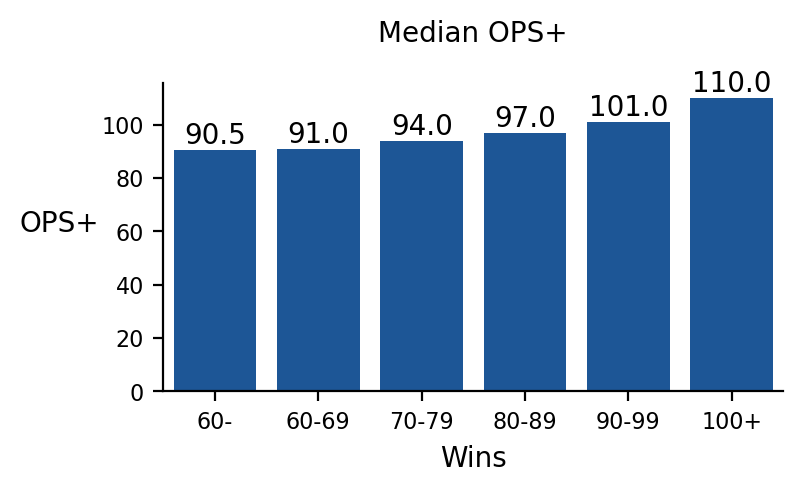

In [8]:
e.plot_median_OPS()

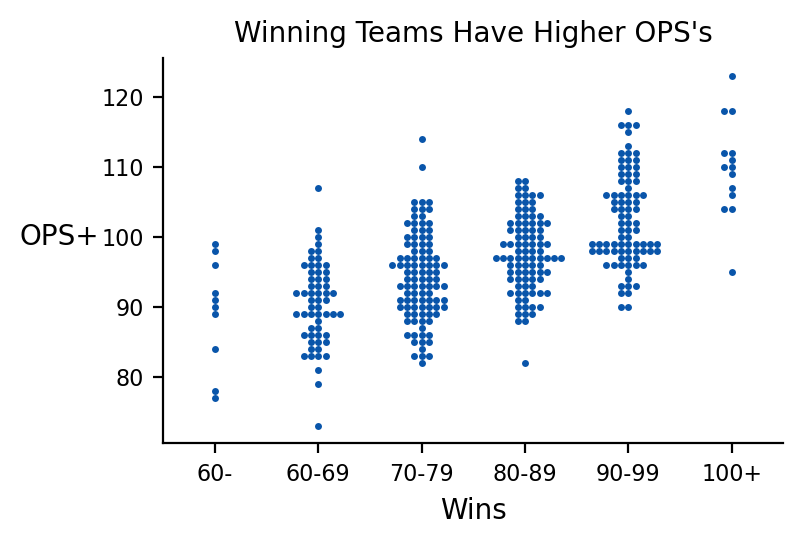

In [9]:
e.plot_OPS_distributions()

Exploration Summary:
- Key Insights:
    - `OPS`, `rOBA`, and `WHIP` are some of the strongest drivers of wins
    - Total Average (`TotA`) and Secondary Average (`SecA`) drive wins more than (regular) Batting Average (`BA`)
    - Pulled balls (`Pull%`) drive more wins than non-pulled hits (`Cent%` and `Oppo%`)
    
Conclusions:
- Winning teams slightly pull the ball more tham losing teams.
- Common stats like average (`BA`), hits (`H`), and home runs (`HR`) don't predict wins as much as advanced/sabermetric stats. However. these stats are likely to remain the "poster stats" due to tradition and simplicity. 
- Although there is a sort of fascination and praise from the media for hitters that are able to spread the ball, more analysis should be done to see how valuable this skill really is (compared to other skills).


Further exploration ideas:
- Gather fielding stats and find strong correlations to win
- See how stat relationships to wins are changing over the years
    - Which stats drive wins from 2005-2009? 2010-2014? 2015-2019?
- Since OPS is a major predictor of Wins, I would want to see which batter stats and features drive OPS the most and which pitcher stats and features reduce OPS against.
- Since batter and pitcher age have a slight positive correlation to wins, it could be valuable analyzing stats on age, perhaps looking into player peaks.

## Modeling: Regression

Best model trained on the following features:
- `OPS+`, `HR_bat`, `BatAge`, `WHIP`, `HR_pit`, `PAge`

Best model was a Linear Regression model, which outperformed Gradient Boosting Regressor models and Neural Networks.

- This says that our features have more of a linear relationship with wins than another complex relationship that the complex models could catch.

In [10]:
tm_batting = pd.read_csv('data/team_batting.csv')
tm_pitching = pd.read_csv('data/team_pitching.csv')

Split data

In [11]:
train, validate, test = m.split_mlb_data(tm_batting, tm_pitching)

**Build Baseline Model:**

- `sklearn`'s `DummyRegressor`, which makes a constant prediction equal to the average team wins in a season.
- Model's predictions are off by about 13 wins, on average, and explain none of the variance.

In [12]:
m.run_baseline_model(train, validate,
                     features=['OPS+'],
                     target=['W']);

Train:	RMSE = 11.57	R2 = 0.0
Test:	RMSE = 12.76	R2 = -0.0


**Best Model: Linear Regression**

Scale data

In [13]:
features = ['OPS+', 'HR_bat', 'BatAge',
            'WHIP', 'HR_pit', 'PAge']
train, validate, test, scaler = m.scale_mlb_data(train, validate, test,
                                                 features=features,
                                                 target=['W'])

Model's predictions are off by about 6 wins, on average, and explain 77% of the variance.

In [14]:
m.run_linear_model(train, validate, features,
                   target=['W'], scaler=scaler);

Train:	RMSE = 5.74	R2 = 0.75
Test:	RMSE = 6.18	R2 = 0.77


,Scaled Coeffs,Unscaled Coeffs
OPS+,26.894108,0.537882
HR_bat,16.306621,0.075494
BatAge,8.286779,1.023059
WHIP,-25.763570,-53.011461
HR_pit,-23.645773,-0.113138
PAge,1.903728,0.240978
Intercept,79.477724,79.477724


The model's scaled coefficients tell us which features impact the model's predictions most. These can be thought of as wins added for having the maximum number of that feature rather than the minimum. So if the maximum number of home runs hit in a season is 200 and the minimum is 100, the model adds 26.89 more wins for a team if they have 200 home runs rather than 100.

The model's unscaled coefficients tell us how many wins are added or subtracted for number of units:

|           |   Scaled Coeffs   |	Unscaled Coeffs  |
| --------- | ----------------- | ------------------ |
|OPS+	    | 26.89        |           0.54 |
|HR_bat	    | 16.30    	|           0.075 |
|BatAge	    | 8.28	        |           1.02 |
|WHIP	    | -25.76     	|         -53.01 |
|HR_pit	    | -23.64	    |          -0.11 |
|PAge	    | 1.90	        |           0.24 |
|Intercept	| 79.47     	|          79.47 |

## Conclusion

### Summary

Analysis
- Batting stats that predict wins:
    - `OPS+`, `TotA`, `rOBA`
- Pitching stats that predict wins:
    - `OPS`, `WHIP`, `FIP`
- Pulled hits leads to more wins than not
- Pitching stats correlate more to wins than offensive stats

Modeling
- Baseline model predictions were off by 12.8 (RMSE) wins, on average, and explained 0 ($R^2$) of the variance.
- Best model was a linear regression model. Predictions were off by 6.2 wins, on average, and explained 77% of the variance in wins.

### Recommendations
- Use the linear regression model to predict team wins from a past season based on their stats to see how 
- Recognize value in advanced and sabermetric stats like `OPS+`, `TotA`, `rOBA`, etc. that predict wins better than traditional stats like `BA`, `HR`, `H`. 
- While it is a unique skill for a hitter to hit the ball in any direction, recognize that this skill may not be as valuable as other skills, like being able to consistently hit the ball hard and draw walks.


### Next Steps
- Analyze player data. Turn one of the important stats, like `OPS`, into the target variable and see which player stats and features drive this target.
- Investigate runs scored in a season and see if I can predict this number.
- Find groups/categories of players and find value and insights in these groups though clustering.

[Back to Top](#top)

---

### References
<a name="ref"></a> 

[Back to Insights](#insights)

1. `OPS` stands for On Base % + Slugging %. On base % is a measure of how often a player ends up on base. Slugging % is a measure of how well a player hits extra base hits.
    - `OPS+` adjusts for hitting conditions like the hitter's ballpark. 100 is league average. 125 is 25% above league average.
        - For example, a Rockies players who frequently hits in a hitter-friendly ballpark may have an `OPS` of .800 and an `OPS+` of 90 whereas a hitter on another team with an `OPS` of .800 may have an `OPS+` of 100

1. `WHIP` walks and hitters allowed per inning

1. `FIP` is a  measure of pitching success independent from fielding support

1. `TotA` is a comprehensive offensive metric that takes into account a player's ability to reach base through hits, walks, and hit by pitches, as well as their ability to advance bases through stolen bases while considering the negative impact of being caught stealing or grounding into double plays. It provides a more complete picture of a player's offensive contribution beyond just their batting average and can help evaluate their overall effectiveness at the plate.


1. `rOBA` is a measure of a player's offensive contributions, weighted in proportion to each event's actual run value

1. `HardH%` is the percent of balls in play with an exit velocity of 95 mph or more

1. `Pull%` is the percent of ait balls put into play that are pulled

1. `Cent%` is the percent of ait balls put into play that are hit center

1. `Oppo%` is the percent of ait balls put into play that are hit to the opposite field

